In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch.unitroot import *
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.metrics import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, normaltest
import scipy.stats as stats
import pylab

In [15]:
df = pd.read_csv('C:\\Users\\amaan\\Downloads\\household_power_consumption.csv')

#df = pd.read_csv("household_power_consumption.csv")
print(df.head())

   index    Date     Time Global_active_power Global_reactive_power Voltage  \
0      0  1/1/07  0:00:00                2.58                 0.136  241.97   
1      1  1/1/07  0:01:00               2.552                   0.1  241.75   
2      2  1/1/07  0:02:00                2.55                   0.1  241.64   
3      3  1/1/07  0:03:00                2.55                   0.1  241.71   
4      4  1/1/07  0:04:00               2.554                   0.1  241.98   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0             10.6              0              0             0.0  
1             10.4              0              0             0.0  
2             10.4              0              0             0.0  
3             10.4              0              0             0.0  
4             10.4              0              0             0.0  


In [16]:
def floating(string):
    try:
        return float(string)
    except:
        return float(0)

In [30]:
float_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in float_cols:
    df[col] = df[col].apply(lambda x: floating(x)).astype(np.float32)

In [18]:
# Check for NaN values
for i in df.columns:
    print(f'{i.capitalize()} has {pd.isna(df[i]).sum()} NaN values')

Index has 0 NaN values
Date has 0 NaN values
Time has 0 NaN values
Global_active_power has 0 NaN values
Global_reactive_power has 0 NaN values
Voltage has 0 NaN values
Global_intensity has 0 NaN values
Sub_metering_1 has 0 NaN values
Sub_metering_2 has 0 NaN values
Sub_metering_3 has 3771 NaN values


In [42]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna()

In [43]:
# Reduce dataset size (use a subset of the data)
df = df.sample(frac=0.1, random_state=42)  # Use 10% of the data


In [44]:
# Split data into train and test sets
test_size = round(len(df) * 0.2)
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

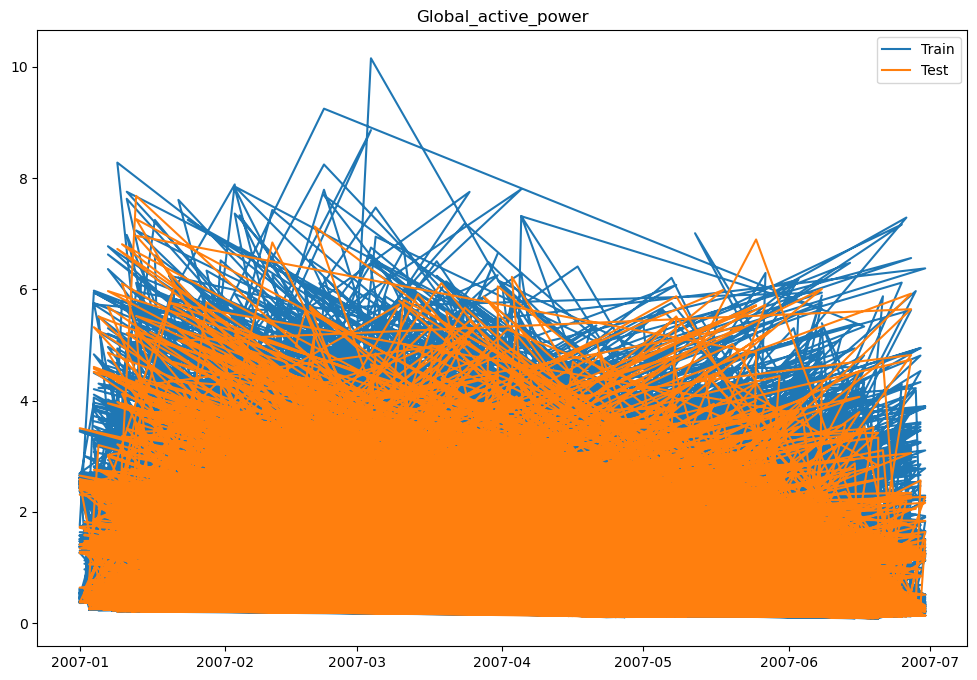

In [34]:
# Visualise the split
col = 'Global_active_power'
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(train['Date'], train[col], label='Train')
plt.plot(test['Date'], test[col], label='Test')
plt.title(f'{col}')
ax.legend(bbox_to_anchor=[1, 1])
plt.show()

In [58]:
# Fit ARIMA model and forecast for 'Global_active_power'
col = 'Global_active_power'
print(f"Fitting model for {col}")

Fitting model for Global_active_power


In [59]:
# Fit ARIMA model
model = auto_arima(
    train[col],
    p=1, d=1, D=1,
    start_q=0, start_p=0,
    max_p=2, max_d=2, max_q=2,
    max_P=2, max_D=2, max_Q=2,
    trace=True, seasonal=True,
    error_action='warn',
    suppress_warnings=True,
    stepwise=True,
    random_state=20,
    n_fits=10  # Adjust to limit memory usage
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7783.240, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7193.996, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7781.240, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6949.953, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6947.953, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7191.996, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.75 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 7.236 seconds


In [60]:
# Print model summary
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2055
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -3470.976
Date:                Thu, 25 Jul 2024   AIC                           6947.953
Time:                        18:34:17   BIC                           6964.835
Sample:                             0   HQIC                          6954.143
                               - 2055                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6681      0.019    -34.507      0.000      -0.706      -0.630
ar.L2         -0.3360      0.020    -17.055      0.000      -0.375      -0.297
sigma2         1.7187      0.037     46.503      0.0

In [61]:
# Forecast next 150 days
forecast_period = 150
forecast = model.predict(n_periods=forecast_period)

# Create date range for forecasts
forecast_dates = pd.date_range(start=test['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D')
predictions = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

# Aggregate to monthly
predictions.set_index('Date', inplace=True)
monthly_predictions = predictions.resample('M').mean()

# Output monthly predictions
print(f"\nMonthly Predictions for {col}:\n")
print(monthly_predictions)


Monthly Predictions for Global_active_power:

            Forecast
Date                
2007-01-31  1.229263
2007-02-28  1.220523
2007-03-31  1.220524
2007-04-30  1.220524
2007-05-31  1.220524
2007-06-30  1.220524


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [62]:
  # Calculate average increase or decrease in consumption
historical_mean = train[col].mean()
predicted_mean = np.mean(forecast)
change = (predicted_mean - historical_mean) / historical_mean * 100

print(f'{col}: {change:.2f}% {"increase" if change > 0 else "decrease"}')

Global_active_power: 6.80% increase
